In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from scipy.optimize import differential_evolution
from numba import jit
import time, multiprocessing, pickle
from scipy.integrate import quad

from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

Nuc = Xe131

In [2]:
@jit(nopython=True)
def RNuFactorGen(theta2):
    N, Z = 77, 54
    sinTheta_Wsq = 0.2387
    Q_W = 1.0*N-(1-4.0*sinTheta_Wsq)*Z # weak nuclear hypercharge
    return ((1.0*N-(1-4.0*sinTheta_Wsq*theta2)*Z)/Q_W)**2

@jit(nopython=True)
def H1Func(datObs, RNu, RWIMP, mu, nuiList, Uncs, exposure):
    temp = nuiList[:-1]@RNu*RNuFactorGen(nuiList[-1]) + RWIMP*mu
    return - exposure*np.sum(datObs*(np.log(exposure)+np.log(temp))-temp) + 0.5*np.sum(((1-nuiList)/Uncs)**2)

def matOneHalfGen(mat):
    va, ve = np.linalg.eigh(mat)
    if np.any(va<0.):
        return [1.]
    return [ve@np.diag(1/va)@np.transpose(ve), ve@np.diag(np.sqrt(va))@np.transpose(ve)]

def symMatGen(diagTerms, ijTerms):
    n = len(diagTerms)
    myMat = np.zeros((n,n))
    for i in range(0, n-1):
        myMat[i, i+1:] = ijTerms[i]
        myMat[i+1:, i] = ijTerms[i]
    myMat = myMat + np.diag(diagTerms)
    return myMat
    
def myMatGen(thetaPrime, s, b, deriWA, deri2WA, sigmaTheta, sigmaWA):
    n = len(b) + 2
    
    deriWATotal = np.sum(deriWA,axis=0)
    vList = thetaPrime[0]*s + np.sum(b, axis=0)
    vInvList = 1/vList
    deriList = np.vstack((s,b,deriWATotal))
    deriNuListT = np.transpose(deriList[1:])
    
    sigmaWA2 = sigmaWA*sigmaWA
    sigmaTheta2 = np.append(sigmaTheta,[sigmaWA])**2

    tempVar1 = 0.5*sigmaWA2*deri2WA*vInvList
    tempVar2 = np.array([tempVar1@deriWA[i] for i in range(len(deriWA))])
    temp = vInvList*(1 + tempVar1)
    tempMat = np.zeros((n,n))
    tempMat[-1,-1] = tempVar1@deri2WA
    tempMat[-1,1:-1] = tempVar2
    tempMat[1:-1,-1] = tempVar2
    ijList = [[np.sum(deriList[i]*deriList[j]*temp) for j in range(i+1,n)] for i in range(0,n-1)]
    diagTerms = np.array([np.sum(deriList[i]*deriList[i]*temp) for i in range(0,n)])
    lddTemp = symMatGen(diagTerms, ijList)
    lddTempDiag = np.append([0.],1/(sigmaTheta2))
    muTemp = np.array([np.sum(tempVar1*deri) for deri in deriList])

    nBin = len(vList)
    ijTerms = [[np.sum(deriNuListT[i]*deriNuListT[j]*sigmaTheta2) for j in range(i+1,nBin)] for i in range(0,nBin-1)]
    diagTerms = [np.sum(deriNuListT[i]*deriNuListT[i]*sigmaTheta2) for i in range(0,nBin)]
    varGauTermConst = np.outer(vInvList, vInvList)*(symMatGen(diagTerms, ijTerms) \
                     - (0.5*sigmaWA2)**2*np.outer(deri2WA, deri2WA))
    
    n = len(b) + 1
    deriList = np.vstack((s,b))
    varGauTermIJ = [[np.sum(np.outer(deriList[i], deriList[j])*varGauTermConst)\
                             for j in range(i+1,n)] for i in range(0,n-1)]
    varGauTermDiag = [np.sum(np.outer(deriList[i], deriList[i])*varGauTermConst)\
                             for i in range(0,n)]
    varGauTerm = symMatGen(varGauTermDiag, varGauTermIJ)
    
    return [lddTemp, tempMat, varGauTerm, lddTempDiag, muTemp]

class WMA(object):
    
    def __init__(self, E_th, E_max, ne, selList=[]):
        nunames, NuUnc, RNuSM = BinnedNeutrinoRates2(E_th,E_max,ne,Nuc,Flux_norm)
        if len(selList) == 0:
            selList = np.linspace(0,len(NuUnc)-1,len(NuUnc),dtype=int)
        else:
            self._selList = selList
        RNuSM = RNuSM[selList]
        iEnd = np.max([len(x[x>1.0e-10]) for x in RNuSM])
        self._RNuSM, self._NuUnc = RNuSM[:,:iEnd], NuUnc[selList]
        # derivation of weak-mixing angle
        N = Nuc.NumberOfNeutrons
        Z = Nuc.NumberOfProtons
        sinTheta_Wsq = 0.2387
        Q_W = 1.0*N-(1-4.0*sinTheta_Wsq)*Z # weak nuclear hypercharge
        self._RNuSMDeri1 = 8*sinTheta_Wsq*Z/Q_W*self._RNuSM
        self._RNuSMDeri2 = 32*(sinTheta_Wsq*Z/Q_W)**2*np.sum(self._RNuSM,axis=0)
        self._deriFactor = 8*sinTheta_Wsq*Z/Q_W
        
        self._temp = [E_th, E_max, ne, Nuc, C_SI, iEnd]
        return None
    
    def _sGen(self, mDM):
        E_th, E_max, ne, Nuc, C_SI, iEnd = self._temp
        dd = 1.0e-4
        xList = np.array([-1.,0,1.])*dd + 1.
        m = np.array([mDM])
        y = BinnedWIMPRate2(E_th, E_max, ne,m,Nuc,C_SI,FormFactorHelm,\
                                      lambda v_min: MeanInverseSpeed_SHM(v_min,sig_v=167.0*1,v_esc=533.0,v_lab=245.6))[1][0][:iEnd]
        return y
    
    def setDMMass(self, mDM):
        self._RWIMP = self._sGen(mDM)
        return 
        
    def tempMatSet(self, sigma0, sigmaWA):
        thetaPrime = np.array([1.])
        RNuSM, NuUncs = self._RNuSM, self._NuUnc
        RWIMP = self._RWIMP*10**(sigma0+45.)
        deriWA, deri2WA = self._RNuSMDeri1, self._RNuSMDeri2
        
        s, b, sigmaTheta = RWIMP, RNuSM, NuUncs
        #lddTemp, varGauTerm = myMatGen(thetaPrime, s1, s2, b, sigmaTheta)
        self._tempMat = myMatGen(thetaPrime, s, b, deriWA, deri2WA, sigmaTheta, sigmaWA)
        return 
    
    def distributionPara(self, exposure):
        lddTemp, tempMat, varGauTerm, lddTempDiag, muTemp = self._tempMat
        ldd = exposure*(lddTemp-tempMat) + np.diag(lddTempDiag)
        mu = exposure*muTemp
        varMat = exposure*lddTemp[:-1,:-1] + exposure**2*varGauTerm
        n = len(mu)
        nk = n - 1
        G3 = ldd.copy()[1:,1:]
        HMat = np.block([[np.zeros((1,1)), np.zeros((1,nk))],[np.zeros((nk,1)), np.linalg.inv(G3)]])
        
        temp = matOneHalfGen(ldd)
        if len(temp)==1:
            return [1]
        lddInv, lddOneHalf = temp
        
        temp = matOneHalfGen(varMat)
        if len(temp)==1:
            return [2]
        varMatInv, varMatOneHalf = temp
        varMatOneHalfInv = np.linalg.inv(varMatOneHalf)
        
        tranMat = np.vstack((np.eye(nk), np.append([0.],self._deriFactor*np.ones(nk-1))))
        #print(tranMat)
        tMat = np.transpose(tranMat)@(lddInv - HMat)@tranMat
        ldd = ldd[:-1,:-1]
        mu = mu[:-1]
        delta = np.append([1.],np.zeros(nk-1))
        
        #tmat = lddInv - HMat
        res1 = varMatOneHalf@tMat@varMatOneHalf
        res2 = np.linalg.eigh(res1)
        orderList = np.flip(np.argsort(res2[0]))
        res2 = [res2[0][orderList], np.transpose(res2[1])[orderList]]
        res3 = varMatOneHalfInv@(mu+ldd@delta)
        #print('1: ', res2[0][:5])
        return [res2[0][0:2], res2[1][0:2], (res2[1][0:2]@res3)**2, res2[0]]
    
    def phiAsiGen(self,sigmaWA,sigma0,exposure):
        lddTemp, tempMat, varGauTerm, lddTempDiag, muTemp = self._tempMat
        ldd = exposure*(lddTemp-tempMat) + np.diag(lddTempDiag)
        mu = exposure*muTemp
        #varMat = exposure*lddTemp[:-1,:-1] + exposure**2*varGauTerm
        n = len(mu)
        nk = n - 1
        G3 = ldd.copy()[1:,1:]
        HMat = np.block([[np.zeros((1,1)), np.zeros((1,nk))],[np.zeros((nk,1)), np.linalg.inv(G3)]])
        
        s, b, sigmaTheta = self._RWIMP*10**(sigma0+45.), self._RNuSM, self._NuUnc
        sigmaTheta = np.append(sigmaTheta,[sigmaWA])
        niuList = (-(np.append([1.],np.zeros(n-1)) - HMat@ldd@np.append([1.],np.zeros(n-1))))[1:] + 1.
        #print((-(np.append([1.],np.zeros(n-1)) - HMat@ldd@np.append([1.],np.zeros(n-1)))) + 1.)
        datObs = s + np.sum(b,axis=0)
        temp = niuList[:-1]@b*RNuFactorGen(niuList[-1])
        phi = 2*(-exposure*np.sum(datObs*(np.log(temp)-np.log(datObs))-(temp-datObs))+ 0.5*np.sum(((1-niuList)/sigmaTheta)**2))
        return phi
    
    def H1Func(self, datObs, nuiList, sigmaWA, exposure, sigma0):
        thetaPrime = np.array([1.])
        RNuSM, NuUncs = self._RNuSM, self._NuUnc
        RWIMP = self._RWIMP*10**(sigma0+45.)
        Uncs = np.append(NuUncs,[sigmaWA])
        RNuSM = np.transpose(np.ascontiguousarray(np.transpose(RNuSM)))
        return H1Func(datObs, RNuSM, RWIMP, nuiList[0], nuiList[1:], Uncs, exposure)
    
class Fog(object):
    
    def __init__(self):
        #self._CLGen = CLGen
        return
    
    def _expoBeta(self, paraSet, expoLog):
        sigmaWA, sigma0, beta = paraSet
        temp = (self._betaGen(sigmaWA, sigma0,10**expoLog)-beta)
        if temp<0:
            return [0, temp]
        else:
            return [1, temp]
    
    def sigmaExpoListGen(self, paraGenClass, sigmaEnd, dExpoLog, beta, sigmaWA):
        sigma0 = self.sigma0Gen(paraGenClass, -5., beta, sigmaWA)
        
        step0 = 0.5**3
        paraGenClass.tempMatSet(sigma0, sigmaWA)
        [expoLog0, temp, recordDat] = biSearch(1., 6, self._expoBeta, [sigmaWA,sigma0,beta], -5., 0)
        recordDatList = [recordDat]
        expoList = np.array([expoLog0])
        sigmaList = np.array([sigma0])
        
        sigmaNext = sigma0-0.1
        paraGenClass.tempMatSet(sigmaNext, sigmaWA)
        [expoLog, temp, recordDat] = biSearch(step0, 3, self._expoBeta, [sigmaWA,sigmaNext,beta], -5., 0)
        expoList = np.append(expoList, expoLog)
        sigmaList = np.append(sigmaList, sigmaNext)
        recordDatList.append(recordDat)
        
        # use the gradient to predict the next discovery cross section with exposure increase of 0.1
        n = 200
        for i in range(2, n):
            #print([sigma0,sigmaNext,(sigmaNext-sigma0)/(expoLog-expoLog0)])
            sigma0Temp = sigmaNext
            sigmaNext = sigma0Temp+(sigmaNext-sigma0)/(expoLog-expoLog0)*dExpoLog
            paraGenClass.tempMatSet(sigmaNext, sigmaWA)
            temp = self._expoBeta([sigmaWA,sigmaNext,beta], expoLog+dExpoLog)[0]
            if temp < 0:
                sigmaNext = sigma0Temp+(sigmaNext-sigma0Temp)/4
            sigma0 = sigma0Temp
            expoLog0 = expoLog
            [expoLog, temp, recordDat] = biSearch(step0, 3, self._expoBeta, [sigmaWA,sigmaNext,beta], expoLog+dExpoLog, 0)
            
            if (sigmaNext>sigma0) or (expoLog<expoLog0):
                break
            
            if check(recordDat):
                expoList = np.append(expoList, expoLog)
                sigmaList = np.append(sigmaList, sigmaNext)
                recordDatList.append(recordDat)
            else:
                break
            if sigmaNext<sigmaEnd:
                break
        return [sigmaList, expoList, recordDatList]
    
    def sigma0Gen(self, paraGenClass, expoLog, beta, sigmaWA):
        self._betaGen = paraGenClass.phiAsiGen
        def tempFunc(paraSet, sigma):
            paraGenClass.tempMatSet(sigma, sigmaWA)
            return self._expoBeta([sigmaWA, sigma, paraSet[0]], expoLog)
        [sigma0, temp, recordDat] = biSearch(1., 2, tempFunc, [beta], -42., 0)
        #print(recordDat)
        return sigma0
    
def check(dat):
    return np.any(dat>0.)&np.any(dat<0.)

def biSearch(step0, n, func, paraSet, para0, flag):
    [temp,para] = [step0,para0]
    tempRes = func(paraSet, para)
    recordPara = np.array([para])
    recordRes = np.array([tempRes[1]])
    if tempRes[0]==flag:
        [sign, label] = [1,0]
    else:
        [sign, label] = [-1,1]
    para = para+sign*temp;
    boundPara = para0+sign*100*step0
    
    for i in range(0,n):
        for j in range(0,100):
            if sign > 0 and (para>boundPara or abs(para-boundPara)<1e-5):
                para = para - 0.5*sign*temp
                break
            elif sign < 0 and (para<boundPara or abs(para-boundPara)<1e-5):
                para = para - 0.5*sign*temp
                break
            tempRes = func(paraSet, para)
            recordPara = np.append(recordPara, para)
            recordRes = np.append(recordRes, tempRes[1])
            if tempRes[0] != label:
                boundPara = para
                para = para - 0.5*sign*temp
                break
            para = para + sign*temp
        temp = 0.5*temp
    return [para, temp, np.array([recordPara,recordRes])]

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from Params import *
from NeutrinoFuncs import *
from PlotFuncs import *
from Like import *
import cmasher as cmr
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from numpy import *

from scipy.ndimage import gaussian_filter1d
from scipy import interpolate

def findPoint(dat):
    y0 = dat[0]
    x0 = np.array(list(map(lambda i: myFindRoot(dat[2][i]), range(len(dat[2])))))
    x0, y0 = 10**x0, 10**y0
    
    x1 = 1/2*(x0[1:]+x0[:-1])
    y1 = -(x1/(1/2*(y0[1:]+y0[:-1]))*(y0[1:]-y0[:-1])/(x0[1:]-x0[:-1]))**(-1)
    y0 = 1/2*(y0[1:]+y0[:-1])
    y1 = gaussian_filter1d(y1,2)
    if y1[0]>2:
        print("The first element exceed 2.")
        return [0,0]
    label = 0
    for i in range(len(y1)):
        if y1[i]>2:
            label = i
            break
    if label > 0:
        temp = np.array([x1[label-1], x1[label], y1[label-1]-2., y1[label]-2., y0[label-1], y0[label]])
        return myFindPoint(temp)
    else:
        print("No elements can exceed 2.")
        return [0,0]    

def myFindPoint(dat):
    x1, x2, y1, y2 = dat[0:4]
    a = (y2-y1)/(x2-x1)
    b = (y1*x2-y2*x1)/(x2-x1)
    x0 = -b/a
    x1, x2, y1, y2 = np.append(dat[0:2], dat[4:])
    a = (y2-y1)/(x2-x1)
    b = (y1*x2-y2*x1)/(x2-x1)
    return [x0, a*x0+b]

def myFindRoot(dat):
    x1, x2, y1, y2 = dat[0,-2], dat[0,-1], dat[1,-2], dat[1,-1]
    a = (y2-y1)/(x2-x1)
    b = (y1*x2-y2*x1)/(x2-x1)
    if a==0:
        res = (x1+x2)/2
    else:
        res = -b/a
    return res

def sigmaNDat(dat):
    y0 = dat[0]
    x0 = np.array(list(map(lambda i: myFindRoot(dat[2][i]), range(len(dat[2])))))
    
    iEnd1, iEnd2 = len(x0), len(x0)
    temp = np.where((x0[1:]-x0[:-1])<0)[0]
    if len(temp)>0:
        iEnd1 = temp[0]
    temp = np.where((y0[1:]-y0[:-1])>0)[0]
    if len(temp)>0:
        iEnd2 = temp[0]
    iEnd = np.min([iEnd1,iEnd2])
    x0, y0 = x0[:iEnd], y0[:iEnd]
    
    x0, y0 = 10**x0, 10**y0
    x1 = 1/2*(x0[1:]+x0[:-1])
    y1 = -(x1/(1/2*(y0[1:]+y0[:-1]))*(y0[1:]-y0[:-1])/(x0[1:]-x0[:-1]))**(-1)
    y0 = 1/2*(y0[1:]+y0[:-1])
    # gaussian_filter1d causes some fluctuations where n < 2, while it should be > 2 
    y1 = gaussian_filter1d(y1,2)
    return [np.log10(y0), y1]

def intDatCut(dat):
    i = 30
    n = len(dat[0])
    x, y = dat[0][-i:], dat[1][-i:]
    temp = np.argwhere(y<2.)
    if len(temp)==0:
        return dat
    else:
        return [dat[0][:n-i+temp[0,0]],dat[1][:n-i+temp[0,0]]]

def plotDatGen(massList, dat):
    NUFLOOR = np.transpose(np.array(list(map(findPoint, dat))))[1]
    
    intDatList = list(map(sigmaNDat, dat))
    intDatList = list(map(intDatCut, intDatList))
    intDatBoundsList = list(map(lambda x: [x[0].min(),x[0].max()],intDatList))
    intFuncList = list(map(lambda x: interpolate.interp1d(x[0],x[1]),intDatList))
    sigRange = np.linspace(-50.,-39,500)
    def intFuncBounds(intFunc, var, bounds, floor):
        if var>bounds[1]:
            return 0.
        elif var<bounds[0]:
            return 2.1
        else:
            temp = intFunc(var)
            if temp > 3.:
                temp2 = 3.2
            elif (temp < 2.) and (var<floor):
                temp2 = 2.1
            else:
                temp2 = temp
            return temp2
    def subFunc(i):
        nList = np.array(list(map(lambda x: intFuncBounds(intFuncList[i], x, intDatBoundsList[i],\
                                                         np.log10(NUFLOOR[i])), sigRange)))
        return nList
    m, sig = np.meshgrid(massList, sigRange)
    n = np.transpose(list(map(subFunc, range(0,len(massList)))))
    return massList, 10**sigRange, n, NUFLOOR

def vFogPlotWMA(res, m_vals, color, target):
    #
    n = 5
    colors = np.zeros([n,4])
    colors[0] = mpl.colors.to_rgba(color)
    colors[:] = mpl.colors.to_rgba(color)
    colors[:,3] = [0., 0.2, 0.4, 0.6, 0.8]
    cmap = mpl.colors.ListedColormap(colors, name='test')
    #
    #
    fig,ax = MakeLimitPlot_SI2023(Annotations=True,Collected=False,\
                     xmin=1.0e-1,xmax=1.0e4,ymin=1e-50,ymax=1e-41,\
                     facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25,\
                     xlab=r"DM mass [GeV]",ylab=r"SI DM-nucleon cross section [cm$^2$]")
    m,sig,DY,floor = plotDatGen(m_vals, res)
    cnt = plt.contourf(m,sig,DY,np.array([1.5, 2., 2.5, 3., 3.5]),\
                       cmap=cmap, vmin=1. , vmax=3.5 )
    for c in cnt.collections:
        c.set_edgecolor("face")
    
    pek = line_background(10,'k')
    #NUFLOOR = np.array([m_vals, np.transpose(np.array(list(map(findPoint2, res))))[1]])
    [edgeX, edgeY] = [m_vals, floor]
    plt.plot(edgeX,edgeY,'-',color=color,lw=3,path_effects=pek,zorder=100)
    plt.plot(NuFloor[0],NuFloor[2],'--',color='black',lw=3,path_effects=pek,zorder=50)
    
    cmap2 = mpl.colors.ListedColormap(colors[1:-1], name='test')
    cmap2.set_under(color=color, alpha=0.)
    cmap2.set_over(color=color, alpha=1.)
    im = plt.pcolormesh(-m,sig,DY,vmax=3.,vmin=1.5,cmap=cmap2,rasterized=True,shading='auto')
    fig.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.1, 0.82, 0.82, 0.02])
    fig.colorbar(im, cax=cbar_ax,orientation='horizontal',extend='both',extendfrac=0.03, ticks=[1.5,2,2.5,3.])
    cbar_ax.xaxis.set_ticks_position('top')
    plt.gcf().text(0.5,0.883,r'Gradient of discovery limit, $n = -({\rm d}\ln\sigma_{\rm DL}/{\rm d}\ln N)^{-1}$',fontsize=22,ha='center')

    #plt.gcf().text(0.82,0.9,r'$\left(\frac{{\rm d}\ln\sigma}{{\rm d}\ln N}\right)^{-1}$',fontsize=35,color='w')
    plt.gcf().text(0.15*(1-0.01),0.16*(1+0.01),r'\bf {0} neutrino fog'.format(target),color='k',fontsize=30,alpha=0.2)
    plt.gcf().text(0.15,0.16,r'\bf {0} neutrino fog'.format(target),color='black',fontsize=30)
    return fig

In [4]:
Eth = E_th
mDM = 5.5
sigma0 = -47.1
exposure = 1.0e1
sigmaWA = 0.1
selList = np.linspace(0,14,15,dtype=int)
fogGen = Fog()
WMA1 = WMA(Eth, E_max, ne, selList)
WMA1.setDMMass(mDM)
WMA1.tempMatSet(sigma0, sigmaWA)
WMA1.distributionPara(exposure)

[array([9.97945296e-01, 1.09980022e-12]),
 array([[ 5.23517037e-02, -3.95725085e-02, -5.73668805e-02,
         -2.24289857e-02, -1.19265975e-03, -9.37055318e-03,
          9.93132737e-01,  1.09557513e-02, -1.60495512e-02,
         -6.00716379e-04,  6.60585574e-03, -1.31868249e-03,
         -3.45766116e-02, -5.67782196e-03,  1.25792382e-03,
         -6.20057913e-02],
        [-7.98836479e-04, -6.37707579e-01,  3.22730384e-01,
          7.82639361e-02,  3.16878562e-02,  5.86302221e-01,
          6.16045956e-03,  2.55038966e-01,  2.24305439e-01,
          5.90492612e-03, -1.57184122e-02, -1.23658980e-01,
          6.75732508e-02,  3.23922314e-02,  1.93714149e-02,
          3.65233888e-02]]),
 array([5.86455929e-03, 2.30905822e-05]),
 array([ 9.97945296e-01,  1.09980022e-12,  8.18258420e-13,  1.58404707e-13,
         9.49571634e-14,  3.38419607e-14,  3.18085221e-15,  8.51922288e-16,
         1.22863088e-16,  4.76703006e-17, -2.22286690e-20, -1.04325784e-16,
        -4.29301829e-16, -8.8588

In [5]:
mDMList = np.logspace(-1,4,400)
def myMul(mDM):
    WMA1.setDMMass(mDM)
    return fogGen.sigmaExpoListGen(WMA1, -50., 0.1, 9., 0.1)

time_start = time.perf_counter()
pool = multiprocessing.Pool(4)
multiple_results = [pool.apply_async(\
        myMul, [mDMList[i]]) for i in range(len(mDMList))]
pool.close()
pool.join()
res1= [res.get() for res in multiple_results]
time_end = time.perf_counter()
print("Time costed: {0} s.".format(time_end-time_start))

Time costed: 194.70764287514612 s.


In [6]:
mypath = os.path.join(os.path.abspath(os.path.pardir),'data', 'MC')
with open(os.path.join(mypath, 'NeutrinoFloor.pickle'), 'rb') as myFile:
    NuFloor = pickle.load(myFile)

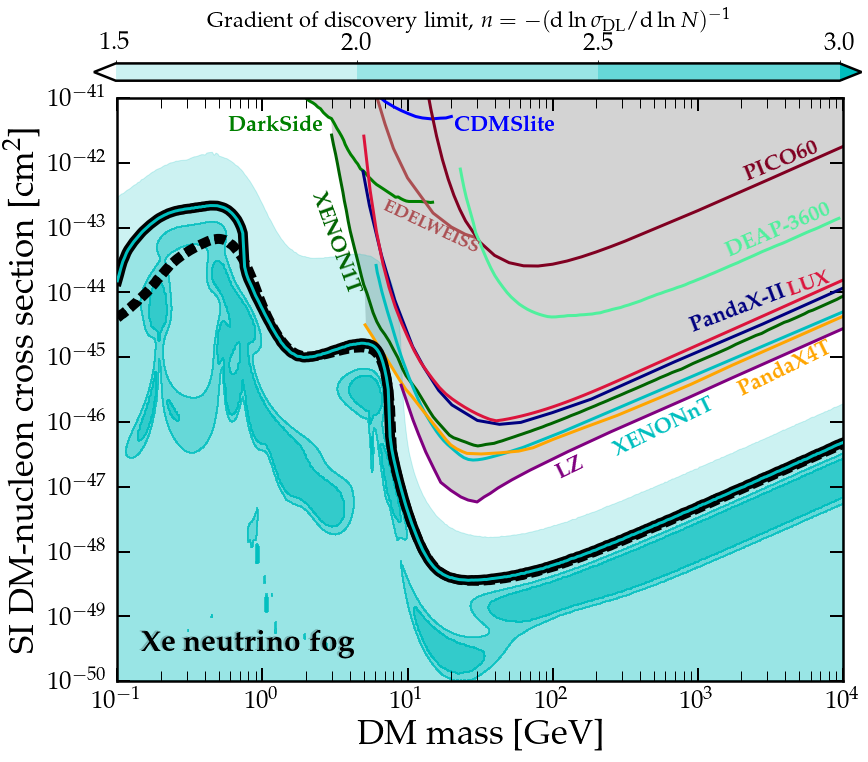

In [7]:
myFog = vFogPlotWMA(res1, mDMList, 'c', 'Xe')

In [8]:
# delete fluctuations caused by numerical errors when exposures are too large
def plotDatGen(massList, dat):
    NUFLOOR = np.transpose(np.array(list(map(findPoint, dat))))[1]
    
    intDatList = list(map(sigmaNDat, dat))
    intDatList = list(map(intDatCut, intDatList))
    intDatBoundsList = list(map(lambda x: [x[0].min(),x[0].max()],intDatList))
    intFuncList = list(map(lambda x: interpolate.interp1d(x[0],x[1]),intDatList))
    sigRange = np.linspace(-50.,-39,500)
    intDatBoundsList2 = np.array(intDatBoundsList)
    cutRange = [np.where(massList<1)[0][-1], np.where(massList<3)[0][-1]]
    #print(intDatBoundsList)
    for i in range(cutRange[0]):
        if intDatBoundsList2[i,0]<-47.:
            intDatBoundsList2[i,0] = -47.
    for i in range(cutRange[0],cutRange[1]):
        intDatBoundsList2[i,0] = -47.-1/(cutRange[1]-cutRange[0])*(i-cutRange[0])
    intDatBoundsList = intDatBoundsList2
    def intFuncBounds(intFunc, var, bounds, floor):
        if var>bounds[1]:
            return 0.
        elif var<bounds[0]:
            return 2.1
        else:
            temp = intFunc(var)
            if temp > 3.:
                temp2 = 3.2
            elif (temp < 2.) and (var<floor):
                temp2 = 2.1
            else:
                temp2 = temp
            return temp2
    def subFunc(i):
        nList = np.array(list(map(lambda x: intFuncBounds(intFuncList[i], x, intDatBoundsList[i],\
                                                         np.log10(NUFLOOR[i])), sigRange)))
        return nList
    m, sig = np.meshgrid(massList, sigRange)
    n = np.transpose(list(map(subFunc, range(0,len(massList)))))
    return massList, 10**sigRange, n, NUFLOOR

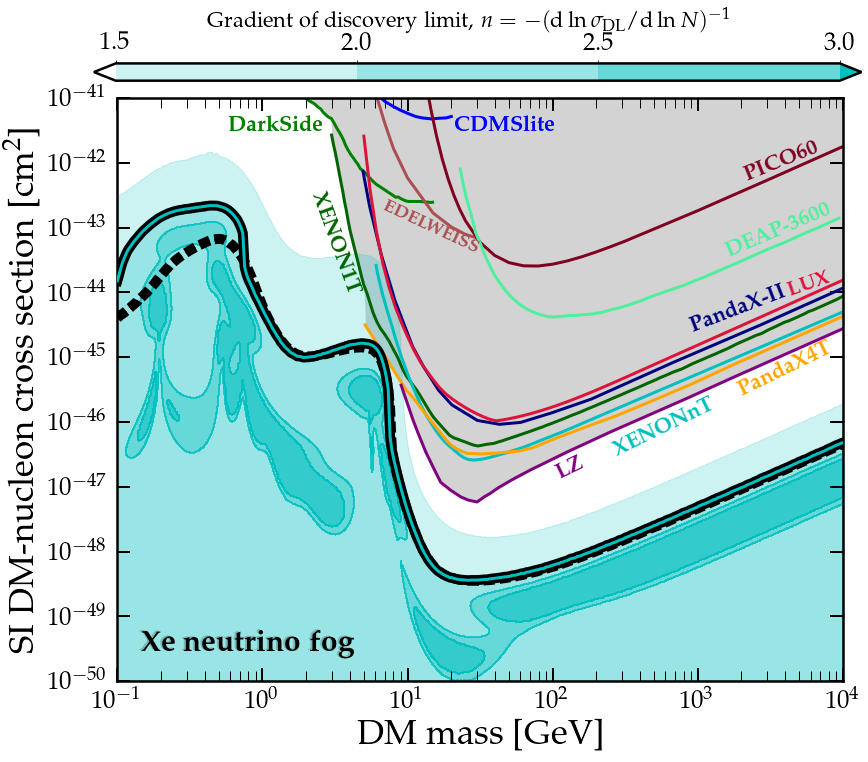

In [9]:
myFog = vFogPlotWMA(res1, mDMList, 'c', 'Xe')

In [10]:
Eth = E_th
mDM = 5.5
sigma0 = -47.1
exposure = 1.0e1
sigmaWA = 0.1
selList = np.array([5])
fogGen = Fog()
WMA2 = WMA(Eth, E_max, ne, selList)
WMA2.setDMMass(mDM)
WMA2.tempMatSet(sigma0, sigmaWA)
WMA2.distributionPara(exposure)

[array([ 7.66939664e-01, -3.13188364e-12]),
 array([[-0.79247754, -0.6099011 ],
        [ 0.6099011 , -0.79247754]]),
 array([0.00128064, 0.00099358]),
 array([ 7.66939664e-01, -3.13188364e-12])]

In [11]:
uncList = [0.000001, 0.02, 0.05, 0.1]
res2=[fogGen.sigmaExpoListGen(WMA2, -49., 0.1, 9., unc) for unc in uncList]

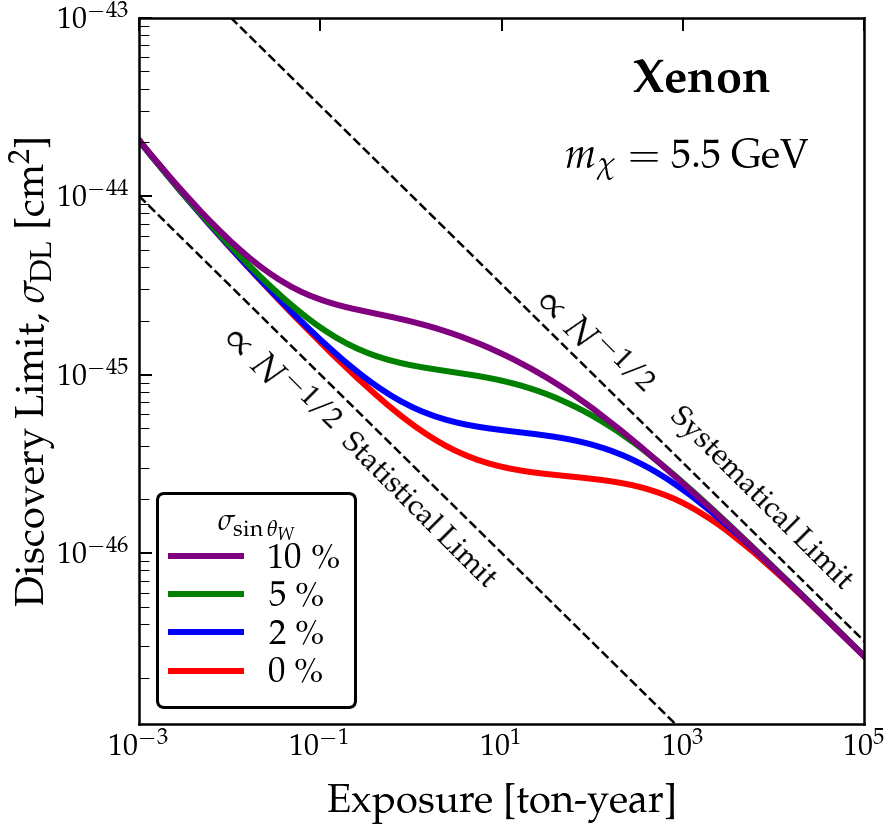

In [14]:
def datObtain(res):
    y0 = res[0]
    x0 = np.array(list(map(lambda i: myFindRoot(res[2][i]), range(len(res[2])))))
    x0 = np.append(x0, res[1][len(res[2]):])
    return 10**x0, 10**y0

def SensitivityCurvePlot(res, Nuc, R_nu, uncList):
    plt.rcParams['axes.linewidth'] = 2.5
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif',size=30)
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'

    m_chi = 5.5
    name = 'Xenon'

    ###### Load in the data
    temp = list([datObtain(x) for x in res])
    sig = [d[1] for d in temp]
    ferrs = np.array(uncList)*100
    ex_vals = temp[0][0]
    
    col = ['r','b','g','purple']
    # Set up subplots
    fig, ax = plt.subplots(figsize=(13,13))

    ylab = r"Discovery Limit, $\sigma_{\rm DL}$ [cm$^2$]"

    ymin = 1.1e-47
    ymax = 1.0e-43

    # Labels
    ax.set_ylabel(ylab,fontsize=40)
    ax.set_xlabel(r'Exposure [ton-year]',fontsize=40,labelpad=20)  # we already handled the x-label with ax1
    ax.set_xlim([1e-3,1e5])
    ax.set_ylim([ymin,ymax])
    # plot
    zo = 0
    for i in flipud(range(0,len(ferrs))):
        ax.loglog(temp[i][0],sig[i],'-',linewidth=6,color=col[i],label=str(int(ferrs[i]))+r' \%',zorder=zo)
        zo = zo-1
    
    plt.gcf().text(0.80,0.80,r'{\bf '+ name+'}',fontsize=47,horizontalalignment='right')
    plt.gcf().text(0.84,0.72,r'$m_\chi = $ '+'5.5 GeV',fontsize=40,horizontalalignment='right')
    
    plt.text(2e1,3.2e-45,r'$\propto N^{-1/2}$',fontsize=38,rotation=-45,verticalalignment='top',horizontalalignment='left')
    plt.text(6e2,7e-46,'Systematical Limit ',fontsize=30,rotation=-45,verticalalignment='top',horizontalalignment='left')
    ax.loglog(np.logspace(-3,5,10),np.logspace(-44,-48,10),'k--',linewidth=2.5)
    ax.loglog(np.logspace(-3,5,10),3.2e1*np.logspace(-44,-48,10),'k--',linewidth=2.5)
    plt.text(7e-3,2e-45,r'$\propto N^{-1/2}$',fontsize=38,rotation=-45,verticalalignment='top',horizontalalignment='left')
    plt.text(1.4e-1,5e-46,'Statistical Limit',fontsize=30,rotation=-45,verticalalignment='top',horizontalalignment='left')

    # Style
    #ax.grid()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(which='major',direction='in',width=2,length=13,bottom=False,top=True,pad=10)
    ax.tick_params(which='minor',direction='in',width=1,length=10,bottom=False,top=True)

    # legend
    leglab = r'$\sigma_{\sin \theta_W}$'
    leg1 = ax.legend(fontsize=35,frameon=True,loc="lower left",framealpha=1,title=leglab,labelspacing=0.1)
    leg1.get_frame().set_linewidth(3)
    leg1.get_frame().set_edgecolor("k")

    plt.show()
    return fig

R_nu = BinnedNeutrinoRates(E_th,E_max,ne,Nuc,Flux_norm)
myCurve=SensitivityCurvePlot(res2, Nuc, R_nu, uncList)

In [15]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
myFog.savefig(os.path.join(myPathFig,'NeutrinoFogWMA.pdf'),bbox_inches='tight')
myFog.savefig(os.path.join(myPathFig,'png','NeutrinoFogWMA.png'),bbox_inches='tight')
myCurve.savefig(os.path.join(myPathFig,'DLWMA.pdf'),bbox_inches='tight')
myCurve.savefig(os.path.join(myPathFig,'png','DLWMA.png'),bbox_inches='tight')